In [1]:
from numpy.random import seed
seed(35)
from tensorflow import set_random_seed
set_random_seed(35)

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.losses import  binary_crossentropy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os

from custom_loss import (recon_loss_abs, make_recon_loss_combi,sparse_recon_loss_abs,
                         make_sparse_recon_loss_combi,
                         sparse_recon_loss_mse, make_sparse_recon_loss_var)

from Autoencoders import autoencoder

from general_loader import ds_from_db
from data_manipulation import remove_outlier, augment_x_linear,augment_x,split_data_X_Y
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.initializers import glorot_normal


/home/anywayed/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from gan_nw_2 import generator_nw_5,discriminator_nw,gan_nw, discriminator_nw_4
from gan_utils import Discrim_pre_train, train_for_n, plot_loss, train_for_n_mono

In [3]:
ds_dic={'pickle_file':'ds180704'}
ds=ds_from_db(**ds_dic)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)

Number of records dropped where no normaliser: 326
Number of records dropped where no normaliser: 119


In [4]:
X,Y,idx,cols=split_data_X_Y(ds.FT.replace([np.inf, -np.inf], np.nan),['Revenues'])
XY,idx=remove_outlier(np.concatenate((X,Y),axis=1),2.5,Y=idx,y_thresh=True)
X[np.isnan(X)]=0

#dump zero y rows
tf=XY[:,200]!=0
XY=XY[tf]
idx=idx[tf]

#check there is at least one dp for every record
assert all(np.sum(XY!=0,axis=1)>0)



amal_train,amal_test,idx_train,idx_test=train_test_split(XY,idx,test_size=0.25,random_state=30)
x_train=amal_train[:,0:199]
x_test=amal_test[:,0:199]
y_test=amal_test[:,200].reshape((x_test.shape[0],1))
y_train=amal_train[:,200].reshape((x_train.shape[0],1))

/home/anywayed/Documents/dis/secTools/data_manipulation.py:32: RuntimeWarning: invalid value encountered in greater
  X[np.abs(X)>level_x]=np.nan


In [5]:
sparse_recon_loss_combi=make_sparse_recon_loss_combi(0.8)
sparse_recon_loss_var=make_sparse_recon_loss_var(sparse_recon_loss_combi)

loss=sparse_recon_loss_combi

metrics=[sparse_recon_loss_mse,sparse_recon_loss_abs,sparse_recon_loss_var]

#early stop setting below is default but explicitly stated here
ES=EarlyStopping(monitor='sparse_recon_loss_combi_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')


train_dic={
           'epochs':100,'batch_size':128
          }

In [6]:
ker_init=glorot_normal(seed=22)
layer_p_dic={'drop_ra':0.1, 'g_noise':0.05, 'ker_init':ker_init}
nodes=[32,16,4,16,32]

In [7]:
pre_gen_compile_dic={'loss':loss,'metrics':metrics,'optimizer':Adam(lr=0.001)}
pre_train_ae=generator_nw_5(x_train,**layer_p_dic,nodes=nodes,y=True)
pre_train_ae.compile(**pre_gen_compile_dic)
pre_x_train=np.concatenate((x_train,y_train),axis=1)
pre_x_test=np.concatenate((x_test,y_test),axis=1)
ES=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
pre_train_ae.fit([x_train,y_train],pre_x_train,validation_data=([x_test,y_test], pre_x_test),
                 epochs=50,batch_size=128,callbacks=[ES])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
financial_cond_input (InputLaye (None, 199)          0                                            
__________________________________________________________________________________________________
financial_manip (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 200)          0           financial_cond_input[0][0]       
                                                                 financial_manip[0][0]            
__________________________________________________________________________________________________
H1_dropout (Dropout)            (None, 200)          0           concatenate_1[0][0]              
__________

2339/2339 [==============================] - 0s 45us/step - loss: 0.0673 - sparse_recon_loss_mse: 0.0559 - sparse_recon_loss_abs: 0.1127 - sparse_recon_loss_var: 0.0879 - val_loss: 0.0649 - val_sparse_recon_loss_mse: 0.0531 - val_sparse_recon_loss_abs: 0.1121 - val_sparse_recon_loss_var: 0.0843
Epoch 12/50
2339/2339 [==============================] - 0s 45us/step - loss: 0.0655 - sparse_recon_loss_mse: 0.0543 - sparse_recon_loss_abs: 0.1105 - sparse_recon_loss_var: 0.0861 - val_loss: 0.0634 - val_sparse_recon_loss_mse: 0.0517 - val_sparse_recon_loss_abs: 0.1101 - val_sparse_recon_loss_var: 0.0828
Epoch 13/50
2339/2339 [==============================] - 0s 45us/step - loss: 0.0651 - sparse_recon_loss_mse: 0.0540 - sparse_recon_loss_abs: 0.1097 - sparse_recon_loss_var: 0.0865 - val_loss: 0.0626 - val_sparse_recon_loss_mse: 0.0510 - val_sparse_recon_loss_abs: 0.1092 - val_sparse_recon_loss_var: 0.0819
Epoch 14/50
2339/2339 [==============================] - 0s 43us/step - loss: 0.0640 - s

Epoch 38/50
2339/2339 [==============================] - 0s 41us/step - loss: 0.0554 - sparse_recon_loss_mse: 0.0444 - sparse_recon_loss_abs: 0.0993 - sparse_recon_loss_var: 0.0744 - val_loss: 0.0525 - val_sparse_recon_loss_mse: 0.0418 - val_sparse_recon_loss_abs: 0.0954 - val_sparse_recon_loss_var: 0.0722
Epoch 39/50
2339/2339 [==============================] - 0s 41us/step - loss: 0.0555 - sparse_recon_loss_mse: 0.0446 - sparse_recon_loss_abs: 0.0991 - sparse_recon_loss_var: 0.0763 - val_loss: 0.0522 - val_sparse_recon_loss_mse: 0.0415 - val_sparse_recon_loss_abs: 0.0948 - val_sparse_recon_loss_var: 0.0722
Epoch 40/50
2339/2339 [==============================] - 0s 41us/step - loss: 0.0550 - sparse_recon_loss_mse: 0.0442 - sparse_recon_loss_abs: 0.0984 - sparse_recon_loss_var: 0.0743 - val_loss: 0.0517 - val_sparse_recon_loss_mse: 0.0410 - val_sparse_recon_loss_abs: 0.0943 - val_sparse_recon_loss_var: 0.0719
Epoch 41/50
2339/2339 [==============================] - 0s 41us/step - loss

In [27]:
weights=pre_train_ae.get_weights()

In [28]:
gen_compile_dic={'loss':loss,'metrics':metrics,'optimizer':Adam(lr=0.001)}
Generator=generator_nw_5(x_train,**layer_p_dic,nodes=nodes,y=True)
Generator.compile(**gen_compile_dic)
Generator.set_weights(weights)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
financial_cond_input (InputLaye (None, 199)          0                                            
__________________________________________________________________________________________________
financial_manip (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 200)          0           financial_cond_input[0][0]       
                                                                 financial_manip[0][0]            
__________________________________________________________________________________________________
H1_dropout (Dropout)            (None, 200)          0           concatenate_7[0][0]              
__________

In [29]:
dis_compile_dic={'loss':binary_crossentropy,'optimizer':Adam(lr=0.001)} #'early_stop':ES}
layer_p_dic={'drop_ra':0.05, 'g_noise':0.05, 'ker_init':ker_init}
Discrim=discriminator_nw_4(x_train,**layer_p_dic,nodes=[64,40,28,16])
Discrim.compile(**dis_compile_dic)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_RealorFake (InputLayer)    (None, 200)               0         
_________________________________________________________________
H1_dropout (Dropout)         (None, 200)               0         
_________________________________________________________________
H1_noise (GaussianNoise)     (None, 200)               0         
_________________________________________________________________
dH1_layer (Dense)            (None, 64)                12864     
_________________________________________________________________
dH1_activation (PReLU)       (None, 64)                64        
_________________________________________________________________
dH2_dropout (Dropout)        (None, 64)                0         
_________________________________________________________________
dH2_noise (GaussianNoise)    (None, 64)                0         
__________

In [30]:
XT_aug, y_hat=Discrim_pre_train(x_train,y_train,Discrim,train_size=1000)

(2000, 200)
Epoch 1/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2647
Epoch 2/10
2000/2000 [==============================] - 0s 95us/step - loss: 0.0255
Epoch 3/10
2000/2000 [==============================] - 0s 98us/step - loss: 0.0095
Epoch 4/10
2000/2000 [==============================] - 0s 95us/step - loss: 0.0037
Epoch 5/10
2000/2000 [==============================] - 0s 97us/step - loss: 0.0023
Epoch 6/10
2000/2000 [==============================] - 0s 95us/step - loss: 0.0017
Epoch 7/10
2000/2000 [==============================] - 0s 102us/step - loss: 0.0021
Epoch 8/10
2000/2000 [==============================] - 0s 94us/step - loss: 0.0021
Epoch 9/10
2000/2000 [==============================] - 0s 94us/step - loss: 0.0011
Epoch 10/10
2000/2000 [==============================] - 0s 94us/step - loss: 0.0012
Accuracy: 100.0 % 2000  of  2000 correct


In [31]:
gan_compile_dic={'loss':[loss,binary_crossentropy],'optimizer':Adam(lr=0.001)}
GAN=gan_nw(Generator,Discrim,x_train)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 199)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 200)          10767       input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_9 (Model)                 (None, 2)            16274       model_8[1][0]                    
Total para

In [32]:
train_dic={'x_train':x_train,'y_train':y_train,'x_test':x_test,'y_test':y_test,
'nb_epoch':800,'plt_frq':100,'batch_size':128,'test_size':64,'Generator':Generator,
'Discriminator':Discrim,'GAN':GAN,'plot':False,'weight_change':True,'alpha':5,'gan_compile_dic':gan_compile_dic,
          'real_smoothing':0.95}

In [33]:
out_dic=train_for_n_mono(**train_dic)

  0%|          | 0/800 [00:00<?, ?it/s]

64/64 [==============================] - 0s 64us/step


  0%|          | 1/800 [00:07<1:35:55,  7.20s/it]

64/64 [==============================] - 0s 72us/step


  0%|          | 4/800 [00:07<24:17,  1.83s/it]  

64/64 [==============================] - 0s 89us/step


  1%|          | 7/800 [00:07<14:01,  1.06s/it]

64/64 [==============================] - 0s 58us/step


  1%|▏         | 10/800 [00:07<09:55,  1.33it/s]

64/64 [==============================] - 0s 75us/step


  2%|▏         | 13/800 [00:07<07:43,  1.70it/s]

64/64 [==============================] - 0s 80us/step


  2%|▏         | 16/800 [00:07<06:20,  2.06it/s]

64/64 [==============================] - 0s 78us/step


  2%|▏         | 19/800 [00:07<05:23,  2.42it/s]

64/64 [==============================] - 0s 74us/step


  3%|▎         | 22/800 [00:07<04:42,  2.76it/s]

64/64 [==============================] - 0s 66us/step


  3%|▎         | 25/800 [00:08<04:10,  3.09it/s]

64/64 [==============================] - 0s 98us/step


  4%|▎         | 28/800 [00:08<03:45,  3.42it/s]

64/64 [==============================] - 0s 65us/step


  4%|▍         | 32/800 [00:08<03:19,  3.84it/s]

64/64 [==============================] - 0s 63us/step


  4%|▍         | 36/800 [00:08<02:59,  4.26it/s]

64/64 [==============================] - 0s 67us/step


  5%|▌         | 40/800 [00:08<02:43,  4.65it/s]

64/64 [==============================] - 0s 64us/step


  6%|▌         | 44/800 [00:08<02:29,  5.04it/s]

64/64 [==============================] - 0s 57us/step


  6%|▌         | 48/800 [00:08<02:18,  5.42it/s]

64/64 [==============================] - 0s 57us/step


  6%|▋         | 52/800 [00:08<02:09,  5.79it/s]

64/64 [==============================] - 0s 86us/step


  7%|▋         | 56/800 [00:09<02:01,  6.14it/s]

64/64 [==============================] - 0s 55us/step


  8%|▊         | 60/800 [00:09<01:54,  6.49it/s]

64/64 [==============================] - 0s 76us/step


  8%|▊         | 64/800 [00:09<01:47,  6.82it/s]

64/64 [==============================] - 0s 64us/step


  8%|▊         | 68/800 [00:09<01:42,  7.15it/s]

64/64 [==============================] - 0s 69us/step


  9%|▉         | 72/800 [00:09<01:37,  7.47it/s]

64/64 [==============================] - 0s 79us/step


 10%|▉         | 76/800 [00:09<01:33,  7.78it/s]

64/64 [==============================] - 0s 55us/step


 10%|█         | 80/800 [00:09<01:29,  8.09it/s]

64/64 [==============================] - 0s 57us/step


 10%|█         | 84/800 [00:10<01:25,  8.38it/s]

64/64 [==============================] - 0s 106us/step


 11%|█         | 88/800 [00:10<01:22,  8.66it/s]

64/64 [==============================] - 0s 56us/step


 12%|█▏        | 92/800 [00:10<01:19,  8.94it/s]

64/64 [==============================] - 0s 50us/step


 12%|█▏        | 96/800 [00:10<01:16,  9.21it/s]

64/64 [==============================] - 0s 67us/step


 12%|█▎        | 100/800 [00:10<01:13,  9.48it/s]

64/64 [==============================] - 0s 61us/step


 13%|█▎        | 104/800 [00:14<01:36,  7.20it/s]

64/64 [==============================] - 0s 80us/step


 14%|█▎        | 108/800 [00:14<01:33,  7.41it/s]

64/64 [==============================] - 0s 61us/step


 14%|█▍        | 112/800 [00:14<01:30,  7.61it/s]

64/64 [==============================] - 0s 62us/step


 14%|█▍        | 116/800 [00:14<01:27,  7.82it/s]

64/64 [==============================] - 0s 73us/step


 15%|█▌        | 120/800 [00:14<01:24,  8.01it/s]

64/64 [==============================] - 0s 83us/step


 16%|█▌        | 124/800 [00:15<01:22,  8.21it/s]

64/64 [==============================] - 0s 64us/step


 16%|█▌        | 128/800 [00:15<01:19,  8.40it/s]

64/64 [==============================] - 0s 60us/step


 16%|█▋        | 132/800 [00:15<01:17,  8.59it/s]

64/64 [==============================] - 0s 64us/step


 17%|█▋        | 136/800 [00:15<01:15,  8.77it/s]

64/64 [==============================] - 0s 53us/step


 18%|█▊        | 140/800 [00:15<01:13,  8.96it/s]

64/64 [==============================] - 0s 54us/step


 18%|█▊        | 144/800 [00:15<01:11,  9.14it/s]

64/64 [==============================] - 0s 71us/step


 18%|█▊        | 148/800 [00:15<01:10,  9.31it/s]

64/64 [==============================] - 0s 58us/step


 19%|█▉        | 152/800 [00:16<01:08,  9.48it/s]

64/64 [==============================] - 0s 61us/step


 20%|█▉        | 156/800 [00:16<01:06,  9.65it/s]

64/64 [==============================] - 0s 79us/step


 20%|██        | 160/800 [00:16<01:05,  9.82it/s]

64/64 [==============================] - 0s 51us/step


 20%|██        | 164/800 [00:16<01:03,  9.98it/s]

64/64 [==============================] - 0s 72us/step


 21%|██        | 168/800 [00:16<01:02, 10.14it/s]

64/64 [==============================] - 0s 55us/step


 22%|██▏       | 172/800 [00:16<01:00, 10.30it/s]

64/64 [==============================] - 0s 52us/step


 22%|██▏       | 176/800 [00:16<00:59, 10.46it/s]

64/64 [==============================] - 0s 67us/step


 22%|██▎       | 180/800 [00:16<00:58, 10.61it/s]

64/64 [==============================] - 0s 55us/step


 23%|██▎       | 184/800 [00:17<00:57, 10.76it/s]

64/64 [==============================] - 0s 95us/step


 24%|██▎       | 188/800 [00:17<00:56, 10.92it/s]

64/64 [==============================] - 0s 82us/step


 24%|██▍       | 192/800 [00:17<00:54, 11.06it/s]

64/64 [==============================] - 0s 65us/step


 24%|██▍       | 196/800 [00:17<00:53, 11.21it/s]

64/64 [==============================] - 0s 82us/step


 25%|██▌       | 200/800 [00:17<00:52, 11.35it/s]

64/64 [==============================] - 0s 66us/step


 26%|██▌       | 204/800 [00:21<01:04,  9.28it/s]

64/64 [==============================] - 0s 87us/step


 26%|██▌       | 208/800 [00:22<01:02,  9.40it/s]

64/64 [==============================] - 0s 77us/step


 26%|██▋       | 212/800 [00:22<01:01,  9.52it/s]

64/64 [==============================] - 0s 68us/step


 27%|██▋       | 215/800 [00:22<01:00,  9.61it/s]

64/64 [==============================] - 0s 70us/step


 27%|██▋       | 218/800 [00:22<00:59,  9.70it/s]

64/64 [==============================] - 0s 65us/step


 28%|██▊       | 222/800 [00:22<00:58,  9.83it/s]

64/64 [==============================] - 0s 70us/step


 28%|██▊       | 225/800 [00:22<00:58,  9.91it/s]

64/64 [==============================] - 0s 60us/step


 28%|██▊       | 228/800 [00:22<00:57, 10.00it/s]

64/64 [==============================] - 0s 85us/step


 29%|██▉       | 231/800 [00:22<00:56, 10.09it/s]

64/64 [==============================] - 0s 84us/step


 29%|██▉       | 234/800 [00:23<00:55, 10.17it/s]

64/64 [==============================] - 0s 73us/step


 30%|██▉       | 238/800 [00:23<00:54, 10.29it/s]

64/64 [==============================] - 0s 75us/step


 30%|███       | 241/800 [00:23<00:53, 10.37it/s]

64/64 [==============================] - 0s 64us/step


 30%|███       | 244/800 [00:23<00:53, 10.45it/s]

64/64 [==============================] - 0s 65us/step


 31%|███       | 248/800 [00:23<00:52, 10.56it/s]

64/64 [==============================] - 0s 69us/step


 32%|███▏      | 252/800 [00:23<00:51, 10.67it/s]

64/64 [==============================] - 0s 82us/step


 32%|███▏      | 255/800 [00:23<00:50, 10.75it/s]

64/64 [==============================] - 0s 85us/step


 32%|███▏      | 258/800 [00:23<00:50, 10.83it/s]

64/64 [==============================] - 0s 70us/step


 33%|███▎      | 262/800 [00:23<00:49, 10.93it/s]

64/64 [==============================] - 0s 55us/step


 33%|███▎      | 266/800 [00:24<00:48, 11.04it/s]

64/64 [==============================] - 0s 57us/step


 34%|███▎      | 269/800 [00:24<00:47, 11.12it/s]

64/64 [==============================] - 0s 54us/step


 34%|███▍      | 272/800 [00:24<00:47, 11.19it/s]

64/64 [==============================] - 0s 52us/step


 34%|███▍      | 276/800 [00:24<00:46, 11.30it/s]

64/64 [==============================] - 0s 68us/step


 35%|███▌      | 280/800 [00:24<00:45, 11.40it/s]

64/64 [==============================] - 0s 58us/step


 35%|███▌      | 283/800 [00:24<00:45, 11.47it/s]

64/64 [==============================] - 0s 72us/step


 36%|███▌      | 286/800 [00:24<00:44, 11.55it/s]

64/64 [==============================] - 0s 70us/step


 36%|███▌      | 289/800 [00:24<00:43, 11.62it/s]

64/64 [==============================] - 0s 55us/step


 36%|███▋      | 292/800 [00:24<00:43, 11.69it/s]

64/64 [==============================] - 0s 71us/step


 37%|███▋      | 296/800 [00:25<00:42, 11.79it/s]

64/64 [==============================] - 0s 68us/step


 37%|███▋      | 299/800 [00:25<00:42, 11.86it/s]

64/64 [==============================] - 0s 70us/step


 38%|███▊      | 302/800 [00:29<00:48, 10.31it/s]

64/64 [==============================] - 0s 73us/step


 38%|███▊      | 306/800 [00:29<00:47, 10.40it/s]

64/64 [==============================] - 0s 59us/step


 39%|███▉      | 310/800 [00:29<00:46, 10.49it/s]

64/64 [==============================] - 0s 52us/step


 39%|███▉      | 314/800 [00:29<00:45, 10.58it/s]

64/64 [==============================] - 0s 55us/step


 40%|███▉      | 318/800 [00:29<00:45, 10.67it/s]

64/64 [==============================] - 0s 65us/step


 40%|████      | 321/800 [00:29<00:44, 10.73it/s]

64/64 [==============================] - 0s 83us/step


 40%|████      | 324/800 [00:30<00:44, 10.79it/s]

64/64 [==============================] - 0s 71us/step


 41%|████      | 327/800 [00:30<00:43, 10.86it/s]

64/64 [==============================] - 0s 87us/step


 41%|████▏     | 330/800 [00:30<00:43, 10.92it/s]

64/64 [==============================] - 0s 73us/step


 42%|████▏     | 333/800 [00:30<00:42, 10.98it/s]

64/64 [==============================] - 0s 49us/step


 42%|████▏     | 336/800 [00:30<00:42, 11.04it/s]

64/64 [==============================] - 0s 72us/step


 42%|████▏     | 339/800 [00:30<00:41, 11.10it/s]

64/64 [==============================] - 0s 66us/step


 43%|████▎     | 342/800 [00:30<00:41, 11.16it/s]

64/64 [==============================] - 0s 80us/step


 43%|████▎     | 345/800 [00:30<00:40, 11.22it/s]

64/64 [==============================] - 0s 70us/step


 44%|████▎     | 348/800 [00:30<00:40, 11.28it/s]

64/64 [==============================] - 0s 80us/step


 44%|████▍     | 351/800 [00:30<00:39, 11.34it/s]

64/64 [==============================] - 0s 52us/step


 44%|████▍     | 355/800 [00:31<00:38, 11.42it/s]

64/64 [==============================] - 0s 72us/step


 45%|████▍     | 358/800 [00:31<00:38, 11.48it/s]

64/64 [==============================] - 0s 75us/step


 45%|████▌     | 361/800 [00:31<00:38, 11.54it/s]

64/64 [==============================] - 0s 119us/step


 46%|████▌     | 364/800 [00:31<00:37, 11.59it/s]

64/64 [==============================] - 0s 72us/step


 46%|████▌     | 368/800 [00:31<00:37, 11.67it/s]

64/64 [==============================] - 0s 79us/step


 46%|████▋     | 371/800 [00:31<00:36, 11.73it/s]

64/64 [==============================] - 0s 77us/step


 47%|████▋     | 374/800 [00:31<00:36, 11.78it/s]

64/64 [==============================] - 0s 78us/step


 47%|████▋     | 378/800 [00:31<00:35, 11.86it/s]

64/64 [==============================] - 0s 91us/step


 48%|████▊     | 381/800 [00:31<00:35, 11.91it/s]

64/64 [==============================] - 0s 62us/step


 48%|████▊     | 384/800 [00:32<00:34, 11.97it/s]

64/64 [==============================] - 0s 57us/step


 48%|████▊     | 388/800 [00:32<00:34, 12.04it/s]

64/64 [==============================] - 0s 74us/step


 49%|████▉     | 391/800 [00:32<00:33, 12.10it/s]

64/64 [==============================] - 0s 65us/step


 49%|████▉     | 394/800 [00:32<00:33, 12.15it/s]

64/64 [==============================] - 0s 67us/step


 50%|████▉     | 397/800 [00:32<00:33, 12.20it/s]

64/64 [==============================] - 0s 69us/step


 50%|█████     | 400/800 [00:32<00:32, 12.25it/s]

64/64 [==============================] - 0s 60us/step


 50%|█████     | 403/800 [00:36<00:36, 10.94it/s]

64/64 [==============================] - 0s 56us/step


 51%|█████     | 406/800 [00:36<00:35, 10.99it/s]

64/64 [==============================] - 0s 62us/step


 51%|█████     | 409/800 [00:37<00:35, 11.04it/s]

64/64 [==============================] - 0s 64us/step


 52%|█████▏    | 412/800 [00:37<00:34, 11.09it/s]

64/64 [==============================] - 0s 56us/step


 52%|█████▏    | 415/800 [00:37<00:34, 11.14it/s]

64/64 [==============================] - 0s 55us/step


 52%|█████▏    | 418/800 [00:37<00:34, 11.19it/s]

64/64 [==============================] - 0s 90us/step


 53%|█████▎    | 421/800 [00:37<00:33, 11.24it/s]

64/64 [==============================] - 0s 57us/step


 53%|█████▎    | 424/800 [00:37<00:33, 11.29it/s]

64/64 [==============================] - 0s 64us/step


 53%|█████▎    | 427/800 [00:37<00:32, 11.33it/s]

64/64 [==============================] - 0s 67us/step


 54%|█████▍    | 430/800 [00:37<00:32, 11.38it/s]

64/64 [==============================] - 0s 54us/step


 54%|█████▍    | 434/800 [00:37<00:31, 11.44it/s]

64/64 [==============================] - 0s 59us/step


 55%|█████▍    | 438/800 [00:38<00:31, 11.51it/s]

64/64 [==============================] - 0s 58us/step


 55%|█████▌    | 442/800 [00:38<00:30, 11.57it/s]

64/64 [==============================] - 0s 61us/step


 56%|█████▌    | 445/800 [00:38<00:30, 11.62it/s]

64/64 [==============================] - 0s 93us/step


 56%|█████▌    | 448/800 [00:38<00:30, 11.67it/s]

64/64 [==============================] - 0s 79us/step


 56%|█████▋    | 451/800 [00:38<00:29, 11.71it/s]

64/64 [==============================] - 0s 56us/step


 57%|█████▋    | 454/800 [00:38<00:29, 11.76it/s]

64/64 [==============================] - 0s 69us/step


 57%|█████▋    | 458/800 [00:38<00:28, 11.82it/s]

64/64 [==============================] - 0s 55us/step


 58%|█████▊    | 462/800 [00:38<00:28, 11.88it/s]

64/64 [==============================] - 0s 104us/step


 58%|█████▊    | 465/800 [00:38<00:28, 11.93it/s]

64/64 [==============================] - 0s 63us/step


 58%|█████▊    | 468/800 [00:39<00:27, 11.97it/s]

64/64 [==============================] - 0s 89us/step


 59%|█████▉    | 472/800 [00:39<00:27, 12.04it/s]

64/64 [==============================] - 0s 76us/step


 60%|█████▉    | 476/800 [00:39<00:26, 12.10it/s]

64/64 [==============================] - 0s 68us/step


 60%|██████    | 480/800 [00:39<00:26, 12.15it/s]

64/64 [==============================] - 0s 60us/step


 60%|██████    | 483/800 [00:39<00:25, 12.20it/s]

64/64 [==============================] - 0s 101us/step


 61%|██████    | 486/800 [00:39<00:25, 12.24it/s]

64/64 [==============================] - 0s 66us/step


 61%|██████    | 489/800 [00:39<00:25, 12.29it/s]

64/64 [==============================] - 0s 60us/step


 62%|██████▏   | 492/800 [00:39<00:24, 12.33it/s]

64/64 [==============================] - 0s 61us/step


 62%|██████▏   | 495/800 [00:40<00:24, 12.37it/s]

64/64 [==============================] - 0s 73us/step


 62%|██████▏   | 498/800 [00:40<00:24, 12.41it/s]

64/64 [==============================] - 0s 68us/step


 63%|██████▎   | 501/800 [00:44<00:26, 11.28it/s]

64/64 [==============================] - 0s 79us/step


 63%|██████▎   | 505/800 [00:44<00:26, 11.34it/s]

64/64 [==============================] - 0s 60us/step


 64%|██████▎   | 508/800 [00:44<00:25, 11.38it/s]

64/64 [==============================] - 0s 86us/step


 64%|██████▍   | 512/800 [00:44<00:25, 11.43it/s]

64/64 [==============================] - 0s 84us/step


 64%|██████▍   | 515/800 [00:44<00:24, 11.48it/s]

64/64 [==============================] - 0s 55us/step


 65%|██████▍   | 518/800 [00:44<00:24, 11.52it/s]

64/64 [==============================] - 0s 59us/step


 65%|██████▌   | 522/800 [00:45<00:24, 11.57it/s]

64/64 [==============================] - 0s 66us/step


 66%|██████▌   | 525/800 [00:45<00:23, 11.61it/s]

64/64 [==============================] - 0s 58us/step


 66%|██████▌   | 528/800 [00:45<00:23, 11.65it/s]

64/64 [==============================] - 0s 70us/step


 66%|██████▋   | 531/800 [00:45<00:23, 11.69it/s]

64/64 [==============================] - 0s 72us/step


 67%|██████▋   | 534/800 [00:45<00:22, 11.73it/s]

64/64 [==============================] - 0s 79us/step


 67%|██████▋   | 538/800 [00:45<00:22, 11.78it/s]

64/64 [==============================] - 0s 76us/step


 68%|██████▊   | 541/800 [00:45<00:21, 11.82it/s]

64/64 [==============================] - 0s 86us/step


 68%|██████▊   | 544/800 [00:45<00:21, 11.86it/s]

64/64 [==============================] - 0s 59us/step


 68%|██████▊   | 547/800 [00:45<00:21, 11.89it/s]

64/64 [==============================] - 0s 79us/step


 69%|██████▉   | 550/800 [00:46<00:20, 11.93it/s]

64/64 [==============================] - 0s 71us/step


 69%|██████▉   | 553/800 [00:46<00:20, 11.97it/s]

64/64 [==============================] - 0s 96us/step


 70%|██████▉   | 556/800 [00:46<00:20, 12.00it/s]

64/64 [==============================] - 0s 75us/step


 70%|███████   | 560/800 [00:46<00:19, 12.06it/s]

64/64 [==============================] - 0s 78us/step


 70%|███████   | 563/800 [00:46<00:19, 12.09it/s]

64/64 [==============================] - 0s 62us/step


 71%|███████   | 566/800 [00:46<00:19, 12.13it/s]

64/64 [==============================] - 0s 72us/step


 71%|███████   | 569/800 [00:46<00:18, 12.17it/s]

64/64 [==============================] - 0s 59us/step


 72%|███████▏  | 572/800 [00:46<00:18, 12.20it/s]

64/64 [==============================] - 0s 71us/step


 72%|███████▏  | 575/800 [00:46<00:18, 12.24it/s]

64/64 [==============================] - 0s 77us/step


 72%|███████▏  | 578/800 [00:47<00:18, 12.27it/s]

64/64 [==============================] - 0s 76us/step


 73%|███████▎  | 581/800 [00:47<00:17, 12.31it/s]

64/64 [==============================] - 0s 62us/step


 73%|███████▎  | 584/800 [00:47<00:17, 12.35it/s]

64/64 [==============================] - 0s 69us/step


 73%|███████▎  | 587/800 [00:47<00:17, 12.38it/s]

64/64 [==============================] - 0s 74us/step


 74%|███████▍  | 590/800 [00:47<00:16, 12.42it/s]

64/64 [==============================] - 0s 78us/step


 74%|███████▍  | 593/800 [00:47<00:16, 12.45it/s]

64/64 [==============================] - 0s 87us/step


 74%|███████▍  | 596/800 [00:47<00:16, 12.49it/s]

64/64 [==============================] - 0s 93us/step


 75%|███████▍  | 599/800 [00:47<00:16, 12.52it/s]

64/64 [==============================] - 0s 56us/step


 75%|███████▌  | 602/800 [00:52<00:17, 11.53it/s]

64/64 [==============================] - 0s 102us/step


 76%|███████▌  | 605/800 [00:52<00:16, 11.57it/s]

64/64 [==============================] - 0s 79us/step


 76%|███████▌  | 608/800 [00:52<00:16, 11.60it/s]

64/64 [==============================] - 0s 81us/step


 76%|███████▋  | 611/800 [00:52<00:16, 11.63it/s]

64/64 [==============================] - 0s 95us/step


 77%|███████▋  | 614/800 [00:52<00:15, 11.67it/s]

64/64 [==============================] - 0s 82us/step


 77%|███████▋  | 617/800 [00:52<00:15, 11.70it/s]

64/64 [==============================] - 0s 54us/step


 78%|███████▊  | 620/800 [00:52<00:15, 11.73it/s]

64/64 [==============================] - 0s 75us/step


 78%|███████▊  | 623/800 [00:52<00:15, 11.77it/s]

64/64 [==============================] - 0s 57us/step


 78%|███████▊  | 626/800 [00:53<00:14, 11.80it/s]

64/64 [==============================] - 0s 78us/step


 79%|███████▊  | 629/800 [00:53<00:14, 11.83it/s]

64/64 [==============================] - 0s 67us/step


 79%|███████▉  | 632/800 [00:53<00:14, 11.86it/s]

64/64 [==============================] - 0s 58us/step


 79%|███████▉  | 635/800 [00:53<00:13, 11.90it/s]

64/64 [==============================] - 0s 76us/step


 80%|███████▉  | 638/800 [00:53<00:13, 11.93it/s]

64/64 [==============================] - 0s 74us/step


 80%|████████  | 641/800 [00:53<00:13, 11.96it/s]

64/64 [==============================] - 0s 91us/step


 80%|████████  | 644/800 [00:53<00:13, 11.99it/s]

64/64 [==============================] - 0s 63us/step


 81%|████████  | 647/800 [00:53<00:12, 12.02it/s]

64/64 [==============================] - 0s 66us/step


 81%|████████▏ | 650/800 [00:53<00:12, 12.05it/s]

64/64 [==============================] - 0s 79us/step


 82%|████████▏ | 653/800 [00:54<00:12, 12.09it/s]

64/64 [==============================] - 0s 78us/step


 82%|████████▏ | 656/800 [00:54<00:11, 12.12it/s]

64/64 [==============================] - 0s 94us/step


 82%|████████▏ | 659/800 [00:54<00:11, 12.15it/s]

64/64 [==============================] - 0s 83us/step


 83%|████████▎ | 662/800 [00:54<00:11, 12.18it/s]

64/64 [==============================] - 0s 81us/step


 83%|████████▎ | 665/800 [00:54<00:11, 12.21it/s]

64/64 [==============================] - 0s 74us/step


 84%|████████▎ | 668/800 [00:54<00:10, 12.24it/s]

64/64 [==============================] - 0s 63us/step


 84%|████████▍ | 671/800 [00:54<00:10, 12.28it/s]

64/64 [==============================] - 0s 98us/step


 84%|████████▍ | 674/800 [00:54<00:10, 12.31it/s]

64/64 [==============================] - 0s 59us/step


 85%|████████▍ | 677/800 [00:54<00:09, 12.34it/s]

64/64 [==============================] - 0s 82us/step


 85%|████████▌ | 680/800 [00:54<00:09, 12.37it/s]

64/64 [==============================] - 0s 69us/step


 85%|████████▌ | 683/800 [00:55<00:09, 12.40it/s]

64/64 [==============================] - 0s 63us/step


 86%|████████▌ | 686/800 [00:55<00:09, 12.43it/s]

64/64 [==============================] - 0s 67us/step


 86%|████████▌ | 689/800 [00:55<00:08, 12.46it/s]

64/64 [==============================] - 0s 61us/step


 86%|████████▋ | 692/800 [00:55<00:08, 12.49it/s]

64/64 [==============================] - 0s 68us/step


 87%|████████▋ | 695/800 [00:55<00:08, 12.52it/s]

64/64 [==============================] - 0s 71us/step


 87%|████████▋ | 698/800 [00:55<00:08, 12.55it/s]

64/64 [==============================] - 0s 77us/step


 88%|████████▊ | 701/800 [01:00<00:08, 11.67it/s]

64/64 [==============================] - 0s 82us/step


 88%|████████▊ | 704/800 [01:00<00:08, 11.70it/s]

64/64 [==============================] - 0s 53us/step


 88%|████████▊ | 707/800 [01:00<00:07, 11.73it/s]

64/64 [==============================] - 0s 72us/step


 89%|████████▉ | 710/800 [01:00<00:07, 11.76it/s]

64/64 [==============================] - 0s 75us/step


 89%|████████▉ | 713/800 [01:00<00:07, 11.78it/s]

64/64 [==============================] - 0s 74us/step


 90%|████████▉ | 716/800 [01:00<00:07, 11.81it/s]

64/64 [==============================] - 0s 58us/step


 90%|████████▉ | 719/800 [01:00<00:06, 11.84it/s]

64/64 [==============================] - 0s 81us/step


 90%|█████████ | 722/800 [01:00<00:06, 11.87it/s]

64/64 [==============================] - 0s 73us/step


 91%|█████████ | 725/800 [01:00<00:06, 11.90it/s]

64/64 [==============================] - 0s 56us/step


 91%|█████████ | 728/800 [01:01<00:06, 11.93it/s]

64/64 [==============================] - 0s 76us/step


 91%|█████████▏| 731/800 [01:01<00:05, 11.96it/s]

64/64 [==============================] - 0s 79us/step


 92%|█████████▏| 734/800 [01:01<00:05, 11.98it/s]

64/64 [==============================] - 0s 86us/step


 92%|█████████▏| 737/800 [01:01<00:05, 12.01it/s]

64/64 [==============================] - 0s 79us/step


 92%|█████████▎| 740/800 [01:01<00:04, 12.04it/s]

64/64 [==============================] - 0s 69us/step


 93%|█████████▎| 743/800 [01:01<00:04, 12.07it/s]

64/64 [==============================] - 0s 61us/step


 93%|█████████▎| 746/800 [01:01<00:04, 12.09it/s]

64/64 [==============================] - 0s 88us/step


 94%|█████████▎| 749/800 [01:01<00:04, 12.12it/s]

64/64 [==============================] - 0s 76us/step


 94%|█████████▍| 752/800 [01:01<00:03, 12.15it/s]

64/64 [==============================] - 0s 66us/step


 94%|█████████▍| 755/800 [01:01<00:03, 12.18it/s]

64/64 [==============================] - 0s 82us/step


 95%|█████████▍| 758/800 [01:02<00:03, 12.20it/s]

64/64 [==============================] - 0s 75us/step


 95%|█████████▌| 761/800 [01:02<00:03, 12.23it/s]

64/64 [==============================] - 0s 61us/step


 96%|█████████▌| 764/800 [01:02<00:02, 12.26it/s]

64/64 [==============================] - 0s 87us/step


 96%|█████████▌| 767/800 [01:02<00:02, 12.29it/s]

64/64 [==============================] - 0s 56us/step


 96%|█████████▋| 770/800 [01:02<00:02, 12.31it/s]

64/64 [==============================] - 0s 92us/step


 97%|█████████▋| 773/800 [01:02<00:02, 12.34it/s]

64/64 [==============================] - 0s 63us/step


 97%|█████████▋| 776/800 [01:02<00:01, 12.37it/s]

64/64 [==============================] - 0s 71us/step


 97%|█████████▋| 779/800 [01:02<00:01, 12.39it/s]

64/64 [==============================] - 0s 92us/step


 98%|█████████▊| 782/800 [01:02<00:01, 12.42it/s]

64/64 [==============================] - 0s 79us/step


 98%|█████████▊| 785/800 [01:03<00:01, 12.45it/s]

64/64 [==============================] - 0s 61us/step


 98%|█████████▊| 788/800 [01:03<00:00, 12.47it/s]

64/64 [==============================] - 0s 60us/step


 99%|█████████▉| 791/800 [01:03<00:00, 12.50it/s]

64/64 [==============================] - 0s 63us/step


 99%|█████████▉| 794/800 [01:03<00:00, 12.53it/s]

64/64 [==============================] - 0s 70us/step


100%|█████████▉| 797/800 [01:03<00:00, 12.55it/s]

64/64 [==============================] - 0s 95us/step


100%|██████████| 800/800 [01:03<00:00, 12.58it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

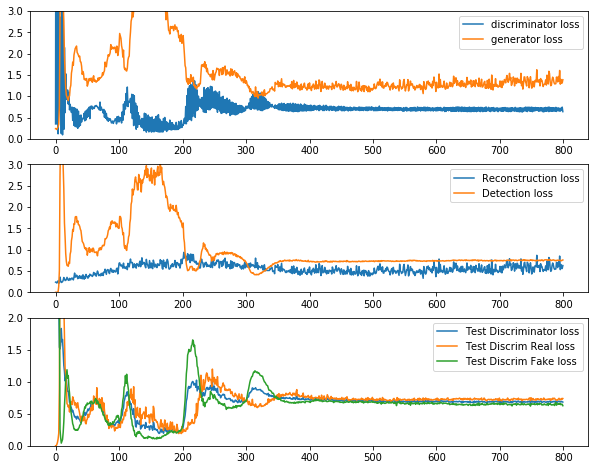

In [34]:
losses=out_dic['losses']
loss_weights=out_dic['weight_hist']
plot_loss(losses,**{'scale_control':[[0,3],[0,3],[0,2]],'loss_weights':loss_weights})

In [16]:
y_hat=Discrim.predict(np.concatenate((x_test,y_test),axis=1))
y_idx = np.argmax(y_hat,axis=1)
print(sum(y_idx==1)/y_idx.shape[0])

0.46025641025641023


In [36]:
min(losses['g'][:,1])


0.032823414

In [35]:
losses['g'][:,1]

array([0.04769225, 0.04656071, 0.04350007, 0.05066127, 0.05364427,
       0.04156693, 0.04758102, 0.07149421, 0.05308666, 0.04608382,
       0.04738474, 0.04999194, 0.0563816 , 0.06941475, 0.06396334,
       0.05540591, 0.0559625 , 0.05976769, 0.07019872, 0.06379389,
       0.05693457, 0.05612643, 0.06548133, 0.05867623, 0.05890428,
       0.06593845, 0.06675844, 0.06496672, 0.05824478, 0.07112447,
       0.09019043, 0.0714018 , 0.07232055, 0.08052065, 0.07738393,
       0.06394519, 0.07415656, 0.06759201, 0.07813323, 0.06579527,
       0.07098639, 0.07580952, 0.0632507 , 0.08201332, 0.07914069,
       0.06142087, 0.07384225, 0.06568869, 0.0839221 , 0.07547123,
       0.07304391, 0.06608099, 0.07730934, 0.07331479, 0.0852965 ,
       0.07900462, 0.08137386, 0.07715166, 0.07442191, 0.08002275,
       0.093246  , 0.0821818 , 0.08938063, 0.08145212, 0.07558376,
       0.08808196, 0.09990821, 0.09214872, 0.07835402, 0.07909153,
       0.08371513, 0.07750252, 0.08874057, 0.08118873, 0.09022

In [21]:
from fake_financial import make_fake_data
x_fake=make_fake_data(np.concatenate((x_test,y_test),axis=1),idx_test,ds,num_fakes=780,method='hard',var_scale=1)
y_hat=Discrim.predict(x_fake)
y_idx = np.argmax(y_hat,axis=1)
sum(y_idx==1)/y_idx.shape[0]

0.4307692307692308

In [20]:
y_hat

array([[0.5233099 , 0.4766901 ],
       [0.47818777, 0.5218122 ],
       [0.52644485, 0.47355518],
       ...,
       [0.45429745, 0.5457025 ],
       [0.5085494 , 0.4914506 ],
       [0.48553014, 0.51446986]], dtype=float32)

In [21]:
import pandas as pd
i=64
composed_imgs=Generator.predict([x_test,y_test])
idx=np.hstack(('Revenues',cols[0:199]))
orig=np.hstack((y_test[i],x_test[i,:]))
fakes=np.hstack((composed_imgs[i][-1],composed_imgs[i][0:-1]))
#orig[orig!=0]
#pd.DataFrame({'originals':orig[orig!=0],'fakes':fakes[orig!=0]},index=idx[orig!=0])
df=pd.DataFrame({'originals':orig,'fakes':fakes},index=idx)
df[df.originals!=0]

,fakes,originals
Revenues,0.000738,0.000738
Assets,1.286911,1.363987
pAssets,1.017834,1.000000
pCashAndCashEquivalentsAtCarryingValue,0.265956,0.371226
CashAndCashEquivalentsAtCarryingValue,0.285897,0.254667
LiabilitiesAndStockholdersEquity,1.308001,1.363987
pLiabilitiesAndStockholdersEquity,1.026067,1.000000
NetIncomeLoss,0.200731,0.071316
pNetIncomeLoss,0.179337,0.395014
pStockholdersEquity,0.904508,0.852010


In [15]:
np.random.binomial(1,0.9,size=(10))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])